# 人工神经元
## 感知器
<img src="./perceptron.png" style="zoom:40%" />
<img src="./perceptron2.png" style="zoom:40%" />

- 当一层中的所有神经元都连接到上一层的每个神经元时，改层称为全连接层或者密集层。
- 感知器的输入被送到称为输入神经元的特殊直通神经元，它们输出被送入的任何输入。
- 所有输入神经元称为输入层。
- 通常会添加一个额外的偏置特征(x<sub>0</sub>=1)：通常使用一种称为偏置神经元的特殊类型的神经元来表示该特征，该神经元始终输出1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [2]:
iris=load_iris()
X=iris.data[:,(2,3)]
y=(iris.target==0).astype(np.int)

In [3]:
per_clf=Perceptron()
per_clf.fit(X,y)

Perceptron()

## 多层感知器和反向传播
- 正向传播和反向传播算法见书。
- 注意以下几点：
    - 随机初始化所有隐藏层的连接权重很重要，否则将训练失败。
    - 将阶跃函数替换成激活函数。
    - 如果没有阶跃函数，那么我们相当于连接多个线性变换，最终得到的只是一个线性变换。

## 回归MLP
<img src="./MLPReg.png" style="zoom:40%" />

## 分类MLP
<img src="./MLPClf.png" style="zoom:40%" />

## TensorFlow Playground
http://playground.tensorflow.org/

# 使用Keras实现MLP
## 使用顺序API构建图像分类器
### 使用keras加载数据集
我们采用Fashion MNIST数据集。7000张图片，每幅28*28像素，有10个类。

In [4]:
from keras.datasets import fashion_mnist

In [5]:
fashion_mnist=fashion_mnist

In [6]:
(X_train_full,y_train_full),(X_test,y_test)=fashion_mnist.load_data()

使用keras加载MNIST或Fashion MNIST时，相较于sklearn的一个重要区别是每个图像都表示成28*28的阵列而不是784的一维阵列。

In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
X_train_full.dtype

dtype('uint8')

数据集已经分好了训练集和测试集，但是没有验证集。另外，我们要使用梯度下降法训练神经网络，因此必须等比例缩放特征。为简单起见，我们将像素强度除以255.0，将像素强度缩放到0-1范围内。

In [9]:
X_valid,X_train=X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_valid,y_train=y_train_full[:5000],y_train_full[5000:]

对于Fashion MNIST我们需要一个类别列表来知道我们要处理的内容。

In [10]:
class_names=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [11]:
# 例如
class_names[y_train[0]]

'Coat'

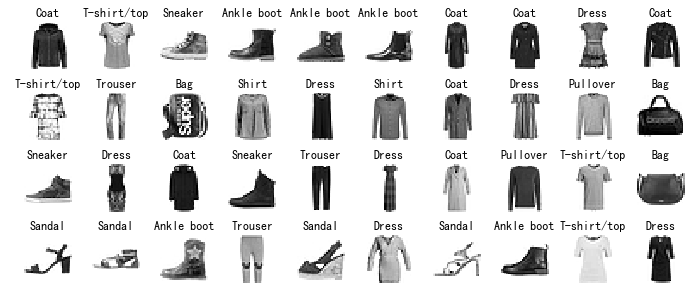

In [12]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### 使用顺序api创建模型
接下来我们用Sequential模型来构建神经网络。

In [13]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense

In [14]:
model=Sequential()
model.add(Flatten(input_shape=[28,28]))
model.add(Dense(300,activation="relu"))
model.add(Dense(100,activation="relu"))
model.add(Dense(10,activation='softmax'))

等同于书上如下代码。

In [15]:
import keras

In [16]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

还等同于如下代码。

In [17]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(
    300, activation='relu'), keras.layers.Dense(100, activation='relu'), keras.layers.Dense(10, activation='softmax')])

- 第一行是创建一个Sequential模型，它仅有顺序连接的单层堆栈组成。
- Flatten层的作用是将每个输入图像转换成一维数组：如果接收到输入数据X，则执行X.reshape(-1,1)。所以该层只是做一些简单的预处理。由于是模型的第一层，应该指定input_shape。或者使用keras.layers.InputLayer作为第一层。
- 接下来是具有300个神经元的隐藏层。它使用Relu作为激活函数。每个Dense管理自己的权重矩阵，其中包含神经元及其输入之间所有的连接权重。它还管理偏置项的一个向量。
- 最后我们添加一个包含10个神经元的Dense输出层，使用softmax作为激活函数。
- 指定activation="relu"等效于activation=keras.activations.relu。

In [18]:
# summary()方法显示模型的所有层。
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


第一个隐藏层的连接权重为784*300，外加300个偏置项，总共235500个参数。

In [19]:
# 可以获取模型的层列表，按其索引获取层，也可以按名称获取。
model.layers

In [20]:
model.layers[1]

还可以使用get_weights()和set_weights()方法访问层的所有参数。

In [21]:
weights,biases=model.layers[1].get_weights()

In [22]:
weights.shape

(784, 300)

In [23]:
biases.shape

(300,)

注意，全连接层进行了随机初始化，并且偏置初始化为0，这是可以的。如果要使用其它初始化方法，则可以在创建层时设置kernel_initializer或bias_initializer。

权重矩阵的形状取决于输入的个数。这就是第一层指定input_shape的原因。如果不指定输入形状也是可以的：当你向模型提供数据时，keras才会真正的构建模型。

### 编译模型
创建模型之后你必须使用compile()方法来指定损失函数和要使用的优化器。还可以选择指定在训练和评估期间要计算的其它指标。

In [24]:
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

- 首先我们使用sparse_categorical_crossentropy损失，因为我们具有稀疏标签（对于每个实例只有一个目标类索引）。
- 相反，如果每个实例的目标类都采用one-hot编码，则我们需要使用categorical_crossentropy损失。
- 如果我们在执行二进制分类，则在输出层应该使用sigmoid激活函数，而不是softmax激活函数，并且使用binary_crossentropy。
- 如果要将稀疏标签转换成one-hot编码，使用keras.utils.to_categorical()函数。反之使用np.argmax(axis=1)函数。

sgd表示我们使用简单的随机梯度下降来训练模型。使用SGD优化器时，调整学习率很重要。因此通常使用optimizer=keras.optimizers.SGD(lr=???)，而不是使用optimizer='sgd'(默认值lr=0.01)来设置学习率。

### 训练和评估模型

In [25]:
history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid))

Epoch 1/30
1719/1719 [==============================] - 18s 2ms/step - loss: 1.0015 - accuracy: 0.6831 - val_loss: 0.5273 - val_accuracy: 0.8142
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5066 - accuracy: 0.8233 - val_loss: 0.4452 - val_accuracy: 0.8494
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4501 - accuracy: 0.8426 - val_loss: 0.4136 - val_accuracy: 0.8568
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4159 - accuracy: 0.8550 - val_loss: 0.4045 - val_accuracy: 0.8626
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3960 - accuracy: 0.8607 - val_loss: 0.4202 - val_accuracy: 0.8502
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3814 - accuracy: 0.8639 - val_loss: 0.3784 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3709 - accuracy: 0.8671 - val_loss: 0.3664 - val_accuracy

可以将validation_split设置为用于验证的训练集比率，而不是使用validation_data参数传递验证集。

如果训练集非常的不平衡，某些类实例过多而另一些实例过少。那么在调用fit()方法时设置class_weight参数来设置权重。这会给代表性不足的类更大的权重。如果你需要每个实例的权重，设置sample_weight参数。你还可以通过validation_data元组的第三项添加到验证集中来提供样本权重。

fit()方法返回一个Histroy对象，其中包含训练参数(history.params)、经历的轮次列表(history.epoch)，最重要的是包含在训练集和验证集上每个轮次结束时测得的损失和额外指标的字典(histroy.history)。

In [26]:
import pandas as pd

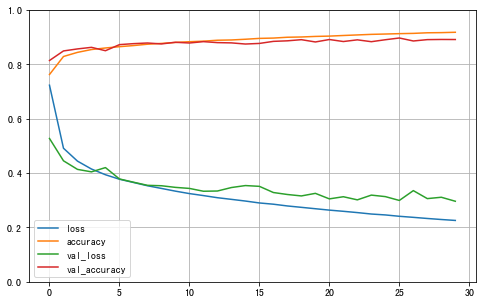

In [27]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

目前模型尚未完全收敛，因为验证损失仍在下降，因此你可以调用fit()方法继续训练。如果你对模型仍不满意应该回头调整超参数。

对模型的验证精度感到满意之后，应该在测试集上对其进行评估泛化误差。可以用evaluate()方法完成操作。

In [28]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 72.7855 - accuracy: 0.8320


[72.7854995727539, 0.8320000171661377]

### 使用模型进行预测

In [29]:
X_new=X_test[:3]
y_prob=model.predict(X_new)
y_prob.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
y_prob

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

对于每个实例，模型估计从0类到9类的概率。如果你只关心估计概率的最高类，则可以使用predict_classes()方法。

In [31]:
y_pred=model.predict_classes(X_new)
y_pred

e:\envs\ai\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([9, 2, 1], dtype=int64)

In [32]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

## 使用顺序API构建回归MLP
我们使用加州住房数据集。

In [33]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [34]:
housing=fetch_california_housing()

In [35]:
X_train_full,X_test,y_train_full,y_test=train_test_split(housing.data,housing.target)
X_train,X_valid,y_train,y_valid=train_test_split(X_train_full,y_train_full)

In [36]:
scalar=StandardScaler()
X_train=scalar.fit_transform(X_train)
X_valid=scalar.transform(X_valid)
X_test=scalar.transform(X_test)

In [37]:
X_train.shape[1:]

(8,)

输出层只有一个神经元，并且不使用激活函数，而损失函数是均方误差。由于数据噪声很大，我们只使用比以前少的神经元单层隐藏层，以免过拟合。

In [38]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(30,activation='relu',input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(1))

In [39]:
model.compile(optimizer='sgd',loss='mean_squared_error')

In [40]:
history=model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.3080 - val_loss: 0.5537
Epoch 2/20
363/363 [==============================] - 0s 864us/step - loss: 5.2862 - val_loss: 0.4567
Epoch 3/20
363/363 [==============================] - 0s 850us/step - loss: 0.4339 - val_loss: 0.4899
Epoch 4/20
363/363 [==============================] - 0s 860us/step - loss: 0.4023 - val_loss: 0.3959
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3811 - val_loss: 0.3889
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3693 - val_loss: 0.3861
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3788 - val_loss: 0.3819
Epoch 8/20
363/363 [==============================] - 0s 809us/step - loss: 0.3771 - val_loss: 0.3984
Epoch 9/20
363/363 [==============================] - 0s 767us/step - loss: 0.3806 - val_loss: 0.3848
Epoch 10/20
363/363 [==============================] - 0s 721us/step - loss: 0.3715 - val_

In [41]:
model.evaluate(X_test,y_test)

162/162 [==============================] - 0s 793us/step - loss: 0.3594


0.35942110419273376

## 使用函数式API构建复杂模型
<img src="./complex.png" style="zoom:40%" />

In [42]:
input_=keras.layers.Input(shape=X_train.shape[1:])
hidden1=keras.layers.Dense(30,activation='relu')(input_)
hidden2=keras.layers.Dense(30,activation='relu')(hidden1)
concat=keras.layers.Concatenate()([input_,hidden2])
output=keras.layers.Dense(1)(concat)
model=keras.Model(inputs=[input_],outputs=[output])

- 首先创建一个Input对象。这是模型需要输入类型的规范，包括其shape和dtype。
- 接下来我们创建一个包含30个神经元的Dense层，使用relu激活函数。创建它后，我们像调用函数一样将其传递给输入。（我们只是告诉keras它应该将各层连接在一起，尚未处理任何实际数据。）
- 我们创建第二个隐藏层，然后再次将其用作函数，我们将第一个隐藏层的输入传递给它。
- 接下来我们创建一个Concatenate层，再次像函数一样立即使用它来合并输入和第二个隐藏层的输出。
- 然后我们创建单个神经元且没有激活函数的输出层。
- 最后我们创建一个keras.Model，指定要使用的输入和输出。

但是如果你想通过宽路径送入特征的子集，而通过深路径送入特征的另一个子集（可能有重合）怎么做？一种解决办法是多个输入。
<img src="./complex2.png" style="zoom:40%" />

In [43]:
input_A=keras.layers.Input(shape=[5],name='wide_input')
input_B=keras.layers.Input(shape=[6],name='deep_input')
hidden1=keras.layers.Dense(30,activation='relu')(input_B)
hidden2=keras.layers.Dense(30,activation='relu')(hidden1)
concat=keras.layers.Concatenate()([input_A,hidden2])
output=keras.layers.Dense(1)(concat)
model=keras.Model(inputs=[input_A,input_B],outputs=[output])

编译时与往常相同。但是使用fit()方法时，必须传递一对矩阵(X_train_A,X_train_B)，各输入一个矩阵，而不是传递单个矩阵X_train。当你调用predict和evaluate时同样如此。

In [44]:
model.compile(loss='mse',optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [45]:
X_train_A,X_train_B=X_train[:,:5],X_train[:,2:]
X_valid_A,X_valid_B=X_valid[:,:5],X_valid[:,2:]
X_test_A,X_test_B=X_test[:,:5],X_test[:,2:]

In [46]:
history=model.fit((X_train_A,X_train_B),y_train,epochs=20,validation_data=((X_valid_A,X_valid_B),y_valid))

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 3.2501 - val_loss: 0.9518
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8819 - val_loss: 0.7801
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7468 - val_loss: 0.7057
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6830 - val_loss: 0.6600
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6560 - val_loss: 0.6298
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5960 - val_loss: 0.5967
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5866 - val_loss: 0.5752
Epoch 8/20
363/363 [==============================] - 0s 972us/step - loss: 0.5573 - val_loss: 0.5593
Epoch 9/20
363/363 [==============================] - 0s 872us/step - loss: 0.5537 - val_loss: 0.5449
Epoch 10/20
363/363 [==============================] - 0s 850us/step - loss: 0.5412 - val_loss: 

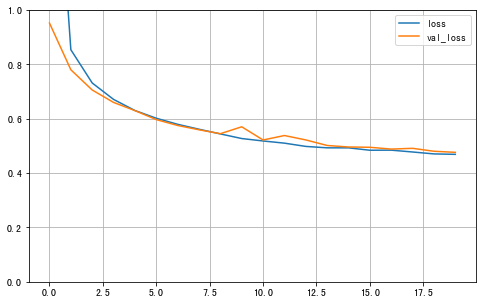

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [48]:
model.evaluate((X_test_A,X_test_B),y_test)

162/162 [==============================] - 0s 664us/step - loss: 0.4765


0.47649243474006653

<img src="./complex3.png" style="zoom:30%" />

In [49]:
input_A=keras.layers.Input(shape=[5],name='wide_input')
input_B=keras.layers.Input(shape=[6],name='deep_input')
hidden1=keras.layers.Dense(30,activation='relu')(input_B)
hidden2=keras.layers.Dense(30,activation='relu')(hidden1)
concat=keras.layers.concatenate([input_A,hidden2])
output=keras.layers.Dense(1,name='main_output')(concat)
aux_output=keras.layers.Dense(1,name='aux_output')(hidden2)
model=keras.Model(inputs=[input_A,input_B],outputs=[output,aux_output])

- 每个输出都应该有自己的损失。
- 默认情况下，keras将这些损失进行简单的累加即可得到训练的最终损失。

我们更关心的是主要输出而不是辅助输出(因为它仅用于正则化)，因此我们要给主要输出损失更大的权值。

In [50]:
model.compile(optimizer='sgd',loss=['mse','mse'],loss_weights=[0.9,0.1])

In [51]:
history=model.fit([X_train_A,X_train_B],[y_train,y_train],epochs=20,validation_data=([X_valid_A,X_valid_B],[y_valid,y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6322 - main_output_loss: 1.4290 - aux_output_loss: 3.4601 - val_loss: 0.6291 - val_main_output_loss: 0.5525 - val_aux_output_loss: 1.3186
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7706 - main_output_loss: 0.7140 - aux_output_loss: 1.2799 - val_loss: 0.5861 - val_main_output_loss: 0.5214 - val_aux_output_loss: 1.1682
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5467 - main_output_loss: 0.4850 - aux_output_loss: 1.1026 - val_loss: 0.5188 - val_main_output_loss: 0.4635 - val_aux_output_loss: 1.0170
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5091 - main_output_loss: 0.4594 - aux_output_loss: 0.9564 - val_loss: 0.4992 - val_main_output_loss: 0.4556 - val_aux_output_loss: 0.8921
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4834 - main_output_loss: 0.4409 - aux_output_loss: 0.8660 - val_loss

当评估模型时，keras将返回总损失和单个损失。

In [52]:
total_loss,main_loss,aux_loss=model.evaluate([X_test_A,X_test_B],[y_test,y_test])

162/162 [==============================] - 0s 859us/step - loss: 0.3712 - main_output_loss: 0.3551 - aux_output_loss: 0.5163


In [53]:
total_loss,main_loss,aux_loss

(0.3712257444858551, 0.35510820150375366, 0.516282320022583)

## 使用子类API构建动态模型
- 顺序式api和函数式api都是声明性质的。
- 只需对Model类进行子类化，在构造函数中创建所需要的层，然后再call方法中执行所需要的层即可。

In [54]:
class WideAndDeepModel(keras.Model):
    def __init__(self,units=30,activation='relu',**kwargs):
        super().__init__(**kwargs) # 处理标准参数
        self.hidden1=keras.layers.Dense(units,activation=activation)
        self.hidden2=keras.layers.Dense(units,activation=activation)
        self.main_output=keras.layers.Dense(1)
        self.aux_output=keras.layers.Dense(1)
        
    def call(self,inputs):
        input_A,input_B=inputs
        hidden1=self.hidden1(input_B)
        hidden2=self.hidden2(hidden1)
        concat=keras.layers.concatenate([input_A,hidden2])
        main_output=self.main_output(concat)
        aux_output=self.aux_output(hidden2)
        return main_output,aux_output

In [55]:
model=WideAndDeepModel()

## 保存和还原模型
keras使用HDF5的格式保存模型的结构和每一层的所有模型参数值。它还可以保存优化器。

In [56]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(30,activation='relu',input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(1))
model.compile(optimizer='sgd',loss='mean_squared_error')
history=model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.4213 - val_loss: 0.5360
Epoch 2/20
363/363 [==============================] - 0s 845us/step - loss: 0.5993 - val_loss: 0.4829
Epoch 3/20
363/363 [==============================] - 0s 850us/step - loss: 0.4509 - val_loss: 0.4502
Epoch 4/20
363/363 [==============================] - 0s 850us/step - loss: 0.4524 - val_loss: 0.4344
Epoch 5/20
363/363 [==============================] - 0s 876us/step - loss: 0.4218 - val_loss: 0.4257
Epoch 6/20
363/363 [==============================] - 0s 878us/step - loss: 0.4068 - val_loss: 0.4457
Epoch 7/20
363/363 [==============================] - 0s 885us/step - loss: 0.4162 - val_loss: 0.4134
Epoch 8/20
363/363 [==============================] - 0s 901us/step - loss: 0.3960 - val_loss: 0.4018
Epoch 9/20
363/363 [==============================] - 0s 887us/step - loss: 0.3809 - val_loss: 0.4000
Epoch 10/20
363/363 [==============================] - 0s 895us/step - loss: 0.3883 

In [57]:
model.save(filepath='my_keras_model.h5')

加载模型同样简单。

In [58]:
model=keras.models.load_model(filepath='./my_keras_model.h5')

如果一次模型训练要训练几个小时，这种情况下不仅应该在训练结束时保存模型，还应该在训练过程中定期保存检查点。使用回调来告诉fit()方法定期保存检查点。

## 使用回调函数
- fit()方法接受一个callbacks参数，该参数使你可以指定keras在训练开始和结束时，每个轮次开始和结束时(甚至在处理每个批量之前和之后)将调用的对象列表。

例如，在训练期间ModelCheckpoint回调会定期保存模型的检查点。

In [59]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(30,activation='relu',input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(1))
model.compile(optimizer='sgd',loss='mean_squared_error')

In [60]:
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath='my_keras_model.h5')
history=model.fit(X_train,y_train,epochs=10,callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 1s 643us/step - loss: 1.2981
Epoch 2/10
363/363 [==============================] - 0s 690us/step - loss: 0.6706
Epoch 3/10
363/363 [==============================] - 0s 661us/step - loss: 0.5132
Epoch 4/10
363/363 [==============================] - 0s 676us/step - loss: 0.4392
Epoch 5/10
363/363 [==============================] - 0s 693us/step - loss: 0.4383
Epoch 6/10
363/363 [==============================] - 0s 696us/step - loss: 0.4320
Epoch 7/10
363/363 [==============================] - 0s 673us/step - loss: 0.4061
Epoch 8/10
363/363 [==============================] - 0s 681us/step - loss: 0.3849
Epoch 9/10
363/363 [==============================] - 0s 694us/step - loss: 0.3940
Epoch 10/10
363/363 [==============================] - 0s 687us/step - loss: 0.3838


此外如果在训练期间使用验证集，则可以在创建ModelCheckpoint时设置save_best_only=True。只有当验证集上的模型性能达到目前最好时，它才会保存模型。这样就不必担心训练时间过长而产生过拟合。

In [61]:
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath='my_keras_model.h5',save_best_only=True)
history=model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid),callbacks=[checkpoint_cb])

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3884 - val_loss: 0.3978
Epoch 2/20
363/363 [==============================] - 0s 868us/step - loss: 0.3852 - val_loss: 0.3943
Epoch 3/20
363/363 [==============================] - 0s 860us/step - loss: 0.3814 - val_loss: 0.4013
Epoch 4/20
363/363 [==============================] - 0s 905us/step - loss: 0.3852 - val_loss: 0.3870
Epoch 5/20
363/363 [==============================] - 0s 923us/step - loss: 0.3792 - val_loss: 0.3826
Epoch 6/20
363/363 [==============================] - 0s 853us/step - loss: 0.3759 - val_loss: 0.3810
Epoch 7/20
363/363 [==============================] - 0s 908us/step - loss: 0.3701 - val_loss: 0.3815
Epoch 8/20
363/363 [==============================] - 0s 923us/step - loss: 0.3656 - val_loss: 0.3810
Epoch 9/20
363/363 [==============================] - 0s 905us/step - loss: 0.3652 - val_loss: 0.3793
Epoch 10/20
363/363 [==============================] - 0s 918us/step - loss: 0.3691 

In [62]:
# 回滚到最优模型
model=keras.models.load_model('./my_keras_model.h5')

实现提前停止的另一种方法是使用EarlyStopping回调。如果在多个轮次(由patience参数定义)的验证集没有任何进展，它将中断训练，并且可以回滚到最优模型。

In [63]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [64]:
history=model.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3481 - val_loss: 0.3838
Epoch 2/100
363/363 [==============================] - 0s 839us/step - loss: 0.3631 - val_loss: 0.3653
Epoch 3/100
363/363 [==============================] - 0s 871us/step - loss: 0.3492 - val_loss: 0.3631
Epoch 4/100
363/363 [==============================] - 0s 863us/step - loss: 0.3467 - val_loss: 0.3630
Epoch 5/100
363/363 [==============================] - 0s 877us/step - loss: 0.3517 - val_loss: 0.3579
Epoch 6/100
363/363 [==============================] - 0s 918us/step - loss: 0.3440 - val_loss: 0.3623
Epoch 7/100
363/363 [==============================] - 0s 908us/step - loss: 0.3431 - val_loss: 0.3533
Epoch 8/100
363/363 [==============================] - 0s 911us/step - loss: 0.3481 - val_loss: 0.4010
Epoch 9/100
363/363 [==============================] - 0s 881us/step - loss: 0.3439 - val_loss: 0.3486
Epoch 10/100
363/363 [==============================] - 0s 882us/step - los

## 使用TensorBoard进行可视化
- tensorboard可用于在训练期间查看学习曲线；比较多次运行的学习曲线；可视化计算图；分析训练统计数据；查看由模型生成的图像；把复杂的多维数据投影到3D并自动进行聚类，等等。
- 要是用它必须修改程序以便将可视化的数据输出到名为事件文件的特殊二进制日志文件中。每个二进制数据记录称为摘要。通常你要把Tensorflow服务器指向根日志目录并配置程序，以使在每次运行时都写入不同的子目录。

首先让我们定义用于TensorBoard日志的根日志目录，再加上一个将根据当前日期和时间生成一个子目录的函数。

In [65]:
import os
root_logdir=os.path.join(os.curdir,'my_logs')
# os.curdir操作系统用来引用当前目录的常量字符串。

In [66]:
def get_run_logdir():
    import time
    run_id=time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir,run_id)

In [67]:
run_logdir=get_run_logdir()

使用Keras的TensorBoard回调。

In [68]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(30,activation='relu',input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(1))
model.compile(optimizer='sgd',loss='mean_squared_error')

In [69]:
tensorboard_cb=keras.callbacks.TensorBoard(run_logdir)
history=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.2591 - val_loss: 0.5214
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5847 - val_loss: 0.4743
Epoch 3/30
363/363 [==============================] - 0s 987us/step - loss: 0.6835 - val_loss: 0.4589
Epoch 4/30
363/363 [==============================] - 0s 923us/step - loss: 0.4323 - val_loss: 0.4398
Epoch 5/30
363/363 [==============================] - 0s 941us/step - loss: 0.4369 - val_loss: 0.4318
Epoch 6/30
363/363 [==============================] - 0s 905us/step - loss: 0.4228 - val_loss: 0.4253
Epoch 7/30
363/363 [==============================] - 0s 948us/step - loss: 0.4055 - val_loss: 0.4133
Epoch 8/30
363/363 [==============================] - 0s 962us/step - loss: 0.3999 - val_loss: 0.4162
Epoch 9/30
363/363 [==============================] - 0s 939us/step - loss: 0.3958 - val_loss: 0.4018
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3880 - va

## 微调神经网络超参数
- 我们可以使用网格搜索或者随机搜索来探寻超参数空间。
- 为此我们要将keras模型包装在模仿常规sklearn回归器的对象中。

**第一步**是创建一个函数，该函数将在给定一组超参数的情况下构建并编译模型。

In [70]:
def build_model(n_hidden=1,n_neurons=30,learning_rate=3e-3,input_shape=[8]):
    model=keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss='mse')
    return model

**第二步**我们基于build_model函数创建一个kerasregressor。

In [73]:
import keras.wrappers.scikit_learn

In [74]:
keras_reg=keras.wrappers.scikit_learn.KerasRegressor(build_model)

kerasregressor对象是使用build_model()构建的一个keras模型的一个包装。由于构建时未使用任何超参数，它使用默认超参数。现在我们能像sklearn回归器一样使用该对象。

In [76]:
keras_reg.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=100,callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 3.0233 - val_loss: 0.6946
Epoch 2/100
363/363 [==============================] - 0s 812us/step - loss: 0.6724 - val_loss: 0.6033
Epoch 3/100
363/363 [==============================] - 0s 771us/step - loss: 0.5730 - val_loss: 0.5621
Epoch 4/100
363/363 [==============================] - 0s 795us/step - loss: 0.5172 - val_loss: 0.5295
Epoch 5/100
363/363 [==============================] - 0s 843us/step - loss: 0.4993 - val_loss: 0.5087
Epoch 6/100
363/363 [==============================] - 0s 839us/step - loss: 0.4902 - val_loss: 0.4936
Epoch 7/100
363/363 [==============================] - 0s 898us/step - loss: 0.4821 - val_loss: 0.4855
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4969 - val_loss: 0.4777
Epoch 9/100
363/363 [==============================] - 0s 885us/step - loss: 0.4633 - val_loss: 0.4704
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0

Epoch 80/100
363/363 [==============================] - 0s 753us/step - loss: 0.3510 - val_loss: 0.3702
Epoch 81/100
363/363 [==============================] - 0s 769us/step - loss: 0.3512 - val_loss: 0.3646
Epoch 82/100
363/363 [==============================] - 0s 771us/step - loss: 0.3416 - val_loss: 0.3636
Epoch 83/100
363/363 [==============================] - 0s 733us/step - loss: 0.3399 - val_loss: 0.3647
Epoch 84/100
363/363 [==============================] - 0s 738us/step - loss: 0.3469 - val_loss: 0.3618
Epoch 85/100
363/363 [==============================] - 0s 754us/step - loss: 0.3448 - val_loss: 0.3618
Epoch 86/100
363/363 [==============================] - 0s 739us/step - loss: 0.3449 - val_loss: 0.3618
Epoch 87/100
363/363 [==============================] - 0s 765us/step - loss: 0.3496 - val_loss: 0.3610
Epoch 88/100
363/363 [==============================] - 0s 736us/step - loss: 0.3443 - val_loss: 0.3603
Epoch 89/100
363/363 [==============================] - 0s 747us

In [77]:
keras_reg.score(X_test,y_test)

162/162 [==============================] - 0s 737us/step - loss: 0.3504


-0.35037633776664734

使用随机搜索较好与网格搜索。

In [78]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [79]:
param_distribs={
    'n_hidden':[0,1,2,3],
    'n_neurons':np.arange(1,100),
    'learning_rate':reciprocal(3e-4,3e-2)
}

In [80]:
rnd_search_cv=RandomizedSearchCV(keras_reg,param_distributions=param_distribs,n_iter=10,cv=3)
rnd_search_cv.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 4.7041 - val_loss: 1.7775
Epoch 2/100
242/242 [==============================] - 0s 986us/step - loss: 1.5217 - val_loss: 0.9533
Epoch 3/100
242/242 [==============================] - 0s 983us/step - loss: 0.9123 - val_loss: 0.8075
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7968 - val_loss: 0.7577
Epoch 5/100
242/242 [==============================] - 0s 890us/step - loss: 0.7691 - val_loss: 0.7311
Epoch 6/100
242/242 [==============================] - 0s 898us/step - loss: 0.7141 - val_loss: 0.7130
Epoch 7/100
242/242 [==============================] - 0s 975us/step - loss: 0.7120 - val_loss: 0.6983
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6874 - val_loss: 0.6849
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6684 - val_loss: 0.6731
Epoch 10/100
242/242 [==============================] - 0s 957us/step - loss: 0.6

242/242 [==============================] - 0s 1ms/step - loss: 0.4146 - val_loss: 0.4257
Epoch 81/100
242/242 [==============================] - 0s 928us/step - loss: 0.4266 - val_loss: 0.4247
Epoch 82/100
242/242 [==============================] - 0s 992us/step - loss: 0.4130 - val_loss: 0.4241
Epoch 83/100
242/242 [==============================] - 0s 962us/step - loss: 0.4114 - val_loss: 0.4235
Epoch 84/100
242/242 [==============================] - 0s 881us/step - loss: 0.4135 - val_loss: 0.4229
Epoch 85/100
242/242 [==============================] - 0s 984us/step - loss: 0.4027 - val_loss: 0.4221
Epoch 86/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3975 - val_loss: 0.4215
Epoch 87/100
242/242 [==============================] - 0s 961us/step - loss: 0.4186 - val_loss: 0.4211
Epoch 88/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4006 - val_loss: 0.4201
Epoch 89/100
242/242 [==============================] - 0s 985us/step - loss: 0.390

Epoch 59/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4105 - val_loss: 0.4434
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4184 - val_loss: 0.4422
Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4284 - val_loss: 0.4410
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4284 - val_loss: 0.4401
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4200 - val_loss: 0.4387
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4142 - val_loss: 0.4378
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4103 - val_loss: 0.4367
Epoch 66/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4171 - val_loss: 0.4357
Epoch 67/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4098 - val_loss: 0.4346
Epoch 68/100
242/242 [==============================] - 0s 947us/step - loss: 0.40

242/242 [==============================] - 0s 1ms/step - loss: 0.4796 - val_loss: 0.4682
Epoch 39/100
242/242 [==============================] - 0s 948us/step - loss: 0.4730 - val_loss: 0.4653
Epoch 40/100
242/242 [==============================] - 0s 894us/step - loss: 0.4539 - val_loss: 0.4627
Epoch 41/100
242/242 [==============================] - 0s 876us/step - loss: 0.4655 - val_loss: 0.4606
Epoch 42/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4675 - val_loss: 0.4580
Epoch 43/100
242/242 [==============================] - 0s 926us/step - loss: 0.4596 - val_loss: 0.4562
Epoch 44/100
242/242 [==============================] - 0s 911us/step - loss: 0.4558 - val_loss: 0.4540
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4465 - val_loss: 0.4520
Epoch 46/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4622 - val_loss: 0.4502
Epoch 47/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4438 - 

Epoch 17/100
242/242 [==============================] - 0s 981us/step - loss: 0.4794 - val_loss: 0.5040
Epoch 18/100
242/242 [==============================] - 0s 939us/step - loss: 0.4706 - val_loss: 0.4975
Epoch 19/100
242/242 [==============================] - 0s 972us/step - loss: 0.4937 - val_loss: 0.4941
Epoch 20/100
242/242 [==============================] - 0s 960us/step - loss: 0.4907 - val_loss: 0.4875
Epoch 21/100
242/242 [==============================] - 0s 952us/step - loss: 0.4860 - val_loss: 0.4835
Epoch 22/100
242/242 [==============================] - 0s 935us/step - loss: 0.4555 - val_loss: 0.4789
Epoch 23/100
242/242 [==============================] - 0s 963us/step - loss: 0.4690 - val_loss: 0.4747
Epoch 24/100
242/242 [==============================] - 0s 967us/step - loss: 0.4532 - val_loss: 0.4710
Epoch 25/100
242/242 [==============================] - 0s 978us/step - loss: 0.4640 - val_loss: 0.4671
Epoch 26/100
242/242 [==============================] - 0s 960us

Epoch 96/100
242/242 [==============================] - 0s 980us/step - loss: 0.3426 - val_loss: 0.3763
Epoch 97/100
242/242 [==============================] - 0s 886us/step - loss: 0.3675 - val_loss: 0.3732
Epoch 98/100
242/242 [==============================] - 0s 952us/step - loss: 0.3473 - val_loss: 0.3733
Epoch 99/100
242/242 [==============================] - 0s 939us/step - loss: 0.3478 - val_loss: 0.3737
Epoch 100/100
121/121 [==============================] - 0s 673us/step - loss: 0.3587
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 3.6826 - val_loss: 1.2315
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0311 - val_loss: 0.8456
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7952 - val_loss: 0.7515
Epoch 4/100
242/242 [==============================] - 0s 993us/step - loss: 0.6913 - val_loss: 0.7103
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6896 - val_loss

242/242 [==============================] - 0s 960us/step - loss: 0.3486 - val_loss: 0.3759
Epoch 75/100
242/242 [==============================] - 0s 973us/step - loss: 0.3740 - val_loss: 0.3751
Epoch 76/100
242/242 [==============================] - 0s 927us/step - loss: 0.3709 - val_loss: 0.3738
Epoch 77/100
242/242 [==============================] - 0s 965us/step - loss: 0.3387 - val_loss: 0.3731
Epoch 78/100
242/242 [==============================] - 0s 933us/step - loss: 0.3646 - val_loss: 0.3730
Epoch 79/100
242/242 [==============================] - 0s 946us/step - loss: 0.3446 - val_loss: 0.3720
Epoch 80/100
242/242 [==============================] - 0s 915us/step - loss: 0.3336 - val_loss: 0.3715
Epoch 81/100
242/242 [==============================] - 0s 906us/step - loss: 0.3484 - val_loss: 0.3713
Epoch 82/100
242/242 [==============================] - 0s 932us/step - loss: 0.3469 - val_loss: 0.3703
Epoch 83/100
242/242 [==============================] - 0s 989us/step - loss:

242/242 [==============================] - 0s 989us/step - loss: 0.4054 - val_loss: 0.3977
Epoch 53/100
242/242 [==============================] - 0s 928us/step - loss: 0.3902 - val_loss: 0.3966
Epoch 54/100
242/242 [==============================] - 0s 945us/step - loss: 0.3779 - val_loss: 0.3956
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3637 - val_loss: 0.3950
Epoch 56/100
242/242 [==============================] - 0s 956us/step - loss: 0.3846 - val_loss: 0.3941
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3795 - val_loss: 0.3942
Epoch 58/100
242/242 [==============================] - 0s 942us/step - loss: 0.3844 - val_loss: 0.3937
Epoch 59/100
242/242 [==============================] - 0s 939us/step - loss: 0.3774 - val_loss: 0.3920
Epoch 60/100
242/242 [==============================] - 0s 935us/step - loss: 0.3799 - val_loss: 0.3915
Epoch 61/100
242/242 [==============================] - 0s 964us/step - loss: 0.3

242/242 [==============================] - 0s 1ms/step - loss: 0.3034 - val_loss: 0.3182
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3007 - val_loss: 0.3643
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2973 - val_loss: 0.3494
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3332 - val_loss: 0.3201
Epoch 24/100
242/242 [==============================] - 0s 952us/step - loss: 0.3034 - val_loss: 0.3219
Epoch 25/100
242/242 [==============================] - 0s 927us/step - loss: 0.2900 - val_loss: 0.3154
Epoch 26/100
242/242 [==============================] - 0s 939us/step - loss: 0.2989 - val_loss: 0.3100
Epoch 27/100
242/242 [==============================] - 0s 991us/step - loss: 0.2887 - val_loss: 0.3149
Epoch 28/100
242/242 [==============================] - 0s 956us/step - loss: 0.2816 - val_loss: 0.3171
Epoch 29/100
242/242 [==============================] - 0s 956us/step - loss: 0.2654 

242/242 [==============================] - 0s 956us/step - loss: 0.2861 - val_loss: 0.2921
Epoch 36/100
242/242 [==============================] - 0s 944us/step - loss: 0.2669 - val_loss: 0.3047
Epoch 37/100
242/242 [==============================] - 0s 902us/step - loss: 0.2733 - val_loss: 0.3058
Epoch 38/100
242/242 [==============================] - 0s 871us/step - loss: 0.2673 - val_loss: 0.2895
Epoch 39/100
242/242 [==============================] - 0s 866us/step - loss: 0.2953 - val_loss: 0.3051
Epoch 40/100
242/242 [==============================] - 0s 914us/step - loss: 0.2710 - val_loss: 0.3093
Epoch 41/100
242/242 [==============================] - 0s 913us/step - loss: 0.2683 - val_loss: 0.2979
Epoch 42/100
242/242 [==============================] - 0s 906us/step - loss: 0.2767 - val_loss: 0.2921
Epoch 43/100
242/242 [==============================] - 0s 894us/step - loss: 0.2676 - val_loss: 0.3101
Epoch 44/100
242/242 [==============================] - 0s 890us/step - loss:

242/242 [==============================] - 0s 1ms/step - loss: 0.8900 - val_loss: 0.6423
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5333 - val_loss: 0.5278
Epoch 9/100
242/242 [==============================] - 0s 829us/step - loss: 0.6017 - val_loss: 0.5723
Epoch 10/100
242/242 [==============================] - 0s 852us/step - loss: 0.6709 - val_loss: 0.5975
Epoch 11/100
242/242 [==============================] - 0s 828us/step - loss: 25.3154 - val_loss: 0.5890
Epoch 12/100
242/242 [==============================] - 0s 819us/step - loss: 0.8209 - val_loss: 0.5387
Epoch 13/100
242/242 [==============================] - 0s 873us/step - loss: 0.5208 - val_loss: 0.5262
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2527 - val_loss: 0.5846
Epoch 15/100
242/242 [==============================] - 0s 894us/step - loss: 7.8016 - val_loss: 0.8533
Epoch 16/100
242/242 [==============================] - 0s 833us/step - loss: 0.7554

Epoch 4/100
242/242 [==============================] - 0s 885us/step - loss: 0.4168 - val_loss: 0.4207
Epoch 5/100
242/242 [==============================] - 0s 857us/step - loss: 0.3865 - val_loss: 0.3997
Epoch 6/100
242/242 [==============================] - 0s 815us/step - loss: 0.3720 - val_loss: 0.5422
Epoch 7/100
242/242 [==============================] - 0s 844us/step - loss: 0.4131 - val_loss: 0.3999
Epoch 8/100
242/242 [==============================] - 0s 870us/step - loss: 0.3684 - val_loss: 0.3958
Epoch 9/100
242/242 [==============================] - 0s 870us/step - loss: 0.3933 - val_loss: 0.3965
Epoch 10/100
242/242 [==============================] - 0s 904us/step - loss: 0.3796 - val_loss: 0.4142
Epoch 11/100
242/242 [==============================] - 0s 818us/step - loss: 0.3726 - val_loss: 0.3776
Epoch 12/100
242/242 [==============================] - 0s 877us/step - loss: 0.3615 - val_loss: 0.3724
Epoch 13/100
242/242 [==============================] - 0s 877us/step 

242/242 [==============================] - 0s 968us/step - loss: 0.2704 - val_loss: 0.3033
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2744 - val_loss: 0.3054
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2677 - val_loss: 0.3365
Epoch 29/100
242/242 [==============================] - 0s 937us/step - loss: 0.2771 - val_loss: 0.3071
Epoch 30/100
242/242 [==============================] - 0s 992us/step - loss: 0.2829 - val_loss: 0.2965
Epoch 31/100
242/242 [==============================] - 0s 935us/step - loss: 0.2893 - val_loss: 0.3089
Epoch 32/100
242/242 [==============================] - 0s 939us/step - loss: 0.2696 - val_loss: 0.3026
Epoch 33/100
121/121 [==============================] - 0s 549us/step - loss: 0.3063
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9469 - val_loss: 0.4605
Epoch 2/100
242/242 [==============================] - 0s 988us/step - loss: 0.4270 - val_loss: 0.4834


242/242 [==============================] - 0s 1ms/step - loss: 0.2677 - val_loss: 0.3356
Epoch 35/100
242/242 [==============================] - 0s 972us/step - loss: 0.2691 - val_loss: 0.3417
Epoch 36/100
242/242 [==============================] - 0s 961us/step - loss: 0.2572 - val_loss: 0.3210
Epoch 37/100
242/242 [==============================] - 0s 987us/step - loss: 0.2805 - val_loss: 0.3170
Epoch 38/100
242/242 [==============================] - 0s 994us/step - loss: 0.2690 - val_loss: 0.3063
Epoch 39/100
242/242 [==============================] - 0s 989us/step - loss: 0.2576 - val_loss: 0.3261
Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2750 - val_loss: 0.2929
Epoch 41/100
242/242 [==============================] - 0s 986us/step - loss: 0.2512 - val_loss: 0.3143
Epoch 42/100
121/121 [==============================] - 0s 659us/step - loss: 0.3009
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.3788 - val_loss: 0.5941

242/242 [==============================] - 0s 1ms/step - loss: 0.2532 - val_loss: 0.3099
Epoch 72/100
242/242 [==============================] - 0s 973us/step - loss: 0.2431 - val_loss: 0.2976
Epoch 73/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2336 - val_loss: 0.2950
Epoch 74/100
121/121 [==============================] - 0s 640us/step - loss: 0.3149
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.2033 - val_loss: 0.5467
Epoch 2/100
242/242 [==============================] - 0s 989us/step - loss: 0.4729 - val_loss: 0.4443
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4073 - val_loss: 0.4353
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4062 - val_loss: 0.4008
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3748 - val_loss: 0.3953
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3569 - val_loss: 0.3970
Epoch 7/100


Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3137 - val_loss: 0.3221
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2826 - val_loss: 0.3151
Epoch 33/100
242/242 [==============================] - 0s 974us/step - loss: 0.2788 - val_loss: 0.3058
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2774 - val_loss: 0.3085
Epoch 35/100
242/242 [==============================] - 0s 990us/step - loss: 0.2818 - val_loss: 0.3103
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2730 - val_loss: 0.3109
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2798 - val_loss: 0.3136
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2837 - val_loss: 0.3076
Epoch 39/100
242/242 [==============================] - 0s 997us/step - loss: 0.2703 - val_loss: 0.3096
Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.5544 - val_loss: 0.5455
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5103 - val_loss: 0.5366
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5226 - val_loss: 0.5259
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5338 - val_loss: 0.5187
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5166 - val_loss: 0.5110
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5097 - val_loss: 0.5058
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5153 - val_loss: 0.4983
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4641 - val_loss: 0.4938
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4555 - val_loss: 0.4892
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4617 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.3659 - val_loss: 0.3834
Epoch 92/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3471 - val_loss: 0.3827
Epoch 93/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3608 - val_loss: 0.3834
Epoch 94/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3785 - val_loss: 0.3817
Epoch 95/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3551 - val_loss: 0.3821
Epoch 96/100
242/242 [==============================] - 0s 948us/step - loss: 0.3693 - val_loss: 0.3809
Epoch 97/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3576 - val_loss: 0.3799
Epoch 98/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3465 - val_loss: 0.3795
Epoch 99/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3469 - val_loss: 0.3787
Epoch 100/100
121/121 [==============================] - 0s 612us/step - loss: 0.3644
Epoch 1

242/242 [==============================] - 0s 958us/step - loss: 0.3532 - val_loss: 0.3817
Epoch 70/100
242/242 [==============================] - 0s 910us/step - loss: 0.3548 - val_loss: 0.3806
Epoch 71/100
242/242 [==============================] - 0s 952us/step - loss: 0.3464 - val_loss: 0.3806
Epoch 72/100
242/242 [==============================] - 0s 953us/step - loss: 0.3506 - val_loss: 0.3794
Epoch 73/100
242/242 [==============================] - 0s 972us/step - loss: 0.3459 - val_loss: 0.3791
Epoch 74/100
242/242 [==============================] - 0s 968us/step - loss: 0.3550 - val_loss: 0.3788
Epoch 75/100
242/242 [==============================] - 0s 997us/step - loss: 0.3531 - val_loss: 0.3777
Epoch 76/100
242/242 [==============================] - 0s 994us/step - loss: 0.3552 - val_loss: 0.3774
Epoch 77/100
242/242 [==============================] - 0s 978us/step - loss: 0.3448 - val_loss: 0.3777
Epoch 78/100
242/242 [==============================] - 0s 935us/step - loss:

242/242 [==============================] - 0s 960us/step - loss: 0.3940 - val_loss: 0.4124
Epoch 48/100
242/242 [==============================] - 0s 965us/step - loss: 0.4032 - val_loss: 0.4106
Epoch 49/100
242/242 [==============================] - 0s 981us/step - loss: 0.3928 - val_loss: 0.4101
Epoch 50/100
242/242 [==============================] - 0s 966us/step - loss: 0.3901 - val_loss: 0.4091
Epoch 51/100
242/242 [==============================] - 0s 894us/step - loss: 0.3903 - val_loss: 0.4076
Epoch 52/100
242/242 [==============================] - 0s 939us/step - loss: 0.3904 - val_loss: 0.4063
Epoch 53/100
242/242 [==============================] - 0s 946us/step - loss: 0.3999 - val_loss: 0.4053
Epoch 54/100
242/242 [==============================] - 0s 906us/step - loss: 0.3832 - val_loss: 0.4050
Epoch 55/100
242/242 [==============================] - 0s 944us/step - loss: 0.3600 - val_loss: 0.4046
Epoch 56/100
242/242 [==============================] - 0s 944us/step - loss:

Epoch 26/100
242/242 [==============================] - 0s 881us/step - loss: 0.3636 - val_loss: 0.3789
Epoch 27/100
242/242 [==============================] - 0s 856us/step - loss: 0.3640 - val_loss: 0.3756
Epoch 28/100
242/242 [==============================] - 0s 894us/step - loss: 0.3664 - val_loss: 0.3797
Epoch 29/100
242/242 [==============================] - 0s 852us/step - loss: 0.3596 - val_loss: 0.3768
Epoch 30/100
242/242 [==============================] - 0s 848us/step - loss: 0.3658 - val_loss: 0.3699
Epoch 31/100
242/242 [==============================] - 0s 848us/step - loss: 0.3642 - val_loss: 0.3702
Epoch 32/100
242/242 [==============================] - 0s 832us/step - loss: 0.3778 - val_loss: 0.3719
Epoch 33/100
242/242 [==============================] - 0s 886us/step - loss: 0.3687 - val_loss: 0.3658
Epoch 34/100
242/242 [==============================] - 0s 880us/step - loss: 0.3579 - val_loss: 0.3724
Epoch 35/100
242/242 [==============================] - 0s 881us

242/242 [==============================] - 0s 828us/step - loss: 0.3444 - val_loss: 0.3623
Epoch 51/100
242/242 [==============================] - 0s 870us/step - loss: 0.3448 - val_loss: 0.3583
Epoch 52/100
242/242 [==============================] - 0s 828us/step - loss: 0.3339 - val_loss: 0.3583
Epoch 53/100
242/242 [==============================] - 0s 844us/step - loss: 0.3462 - val_loss: 0.3645
Epoch 54/100
242/242 [==============================] - 0s 891us/step - loss: 0.3469 - val_loss: 0.3660
Epoch 55/100
242/242 [==============================] - 0s 901us/step - loss: 0.3530 - val_loss: 0.3630
Epoch 56/100
242/242 [==============================] - 0s 993us/step - loss: 0.3562 - val_loss: 0.3618
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3507 - val_loss: 0.3631
Epoch 58/100
242/242 [==============================] - 0s 948us/step - loss: 0.3391 - val_loss: 0.3591
Epoch 59/100
242/242 [==============================] - 0s 949us/step - loss: 0

242/242 [==============================] - 0s 850us/step - loss: 0.3506 - val_loss: 0.3594
Epoch 68/100
242/242 [==============================] - 0s 969us/step - loss: 0.3496 - val_loss: 0.3535
Epoch 69/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3457 - val_loss: 0.3509
Epoch 70/100
242/242 [==============================] - 0s 795us/step - loss: 0.3418 - val_loss: 0.3540
Epoch 71/100
242/242 [==============================] - 0s 952us/step - loss: 0.3372 - val_loss: 0.3495
Epoch 72/100
242/242 [==============================] - 0s 889us/step - loss: 0.3391 - val_loss: 0.3539
Epoch 73/100
242/242 [==============================] - 0s 879us/step - loss: 0.3387 - val_loss: 0.3481
Epoch 74/100
242/242 [==============================] - 0s 877us/step - loss: 0.3513 - val_loss: 0.3607
Epoch 75/100
242/242 [==============================] - 0s 886us/step - loss: 0.3338 - val_loss: 0.3544
Epoch 76/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3

242/242 [==============================] - 0s 889us/step - loss: 0.2773 - val_loss: 0.3136
Epoch 63/100
242/242 [==============================] - 0s 907us/step - loss: 0.2815 - val_loss: 0.3088
Epoch 64/100
242/242 [==============================] - 0s 932us/step - loss: 0.2824 - val_loss: 0.3129
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2821 - val_loss: 0.3101
Epoch 66/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2903 - val_loss: 0.3067
Epoch 67/100
242/242 [==============================] - 0s 944us/step - loss: 0.2830 - val_loss: 0.3132
Epoch 68/100
242/242 [==============================] - 0s 923us/step - loss: 0.2784 - val_loss: 0.3112
Epoch 69/100
242/242 [==============================] - 0s 931us/step - loss: 0.2791 - val_loss: 0.3061
Epoch 70/100
242/242 [==============================] - 0s 890us/step - loss: 0.2676 - val_loss: 0.3036
Epoch 71/100
242/242 [==============================] - 0s 861us/step - loss: 0.2

242/242 [==============================] - 0s 954us/step - loss: 0.3065 - val_loss: 0.3279
Epoch 41/100
242/242 [==============================] - 0s 962us/step - loss: 0.2943 - val_loss: 0.3320
Epoch 42/100
242/242 [==============================] - 0s 917us/step - loss: 0.2914 - val_loss: 0.3300
Epoch 43/100
242/242 [==============================] - 0s 972us/step - loss: 0.3087 - val_loss: 0.3281
Epoch 44/100
242/242 [==============================] - 0s 926us/step - loss: 0.2912 - val_loss: 0.3263
Epoch 45/100
242/242 [==============================] - 0s 897us/step - loss: 0.2957 - val_loss: 0.3337
Epoch 46/100
242/242 [==============================] - 0s 979us/step - loss: 0.3057 - val_loss: 0.3247
Epoch 47/100
242/242 [==============================] - 0s 991us/step - loss: 0.2784 - val_loss: 0.3222
Epoch 48/100
242/242 [==============================] - 0s 956us/step - loss: 0.2896 - val_loss: 0.3268
Epoch 49/100
242/242 [==============================] - 0s 868us/step - loss:

Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3405 - val_loss: 0.3667
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3739 - val_loss: 0.3615
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3491 - val_loss: 0.3617
Epoch 25/100
242/242 [==============================] - 0s 960us/step - loss: 0.3391 - val_loss: 0.3584
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3307 - val_loss: 0.3558
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3313 - val_loss: 0.3614
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3440 - val_loss: 0.3553
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3366 - val_loss: 0.3582
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3381 - val_loss: 0.3545
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.32

e:\envs\ai\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [-4.01807606e-01 -3.58172725e-01             nan -5.56665436e+24
             nan -3.12869936e-01 -3.27100774e-01 -3.66168082e-01
 -3.61552586e-01 -3.07083527e-01]
  category=UserWarning


363/363 [==============================] - 1s 1ms/step - loss: 1.5299 - val_loss: 0.5831
Epoch 2/100
363/363 [==============================] - 0s 829us/step - loss: 0.5412 - val_loss: 0.4815
Epoch 3/100
363/363 [==============================] - 0s 973us/step - loss: 0.4557 - val_loss: 0.4525
Epoch 4/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4363 - val_loss: 0.4371
Epoch 5/100
363/363 [==============================] - 0s 788us/step - loss: 0.4039 - val_loss: 0.4185
Epoch 6/100
363/363 [==============================] - 0s 807us/step - loss: 0.3961 - val_loss: 0.4042
Epoch 7/100
363/363 [==============================] - 0s 786us/step - loss: 0.3960 - val_loss: 0.3929
Epoch 8/100
363/363 [==============================] - 0s 858us/step - loss: 0.3675 - val_loss: 0.3901
Epoch 9/100
363/363 [==============================] - 0s 780us/step - loss: 0.3719 - val_loss: 0.3811
Epoch 10/100
363/363 [==============================] - 0s 817us/step - loss: 0.3806 - va

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F98C56CB48>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F990B21308>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [83]:
rnd_search_cv.best_params_

{'learning_rate': 0.006469484918566646, 'n_hidden': 2, 'n_neurons': 62}

In [85]:
rnd_search_cv.best_score_

-0.307083527247111

In [86]:
model=rnd_search_cv.best_estimator_.model

In [87]:
model.save(filepath='./best_model.h5')